In [32]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score
import math

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=5)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for j, (x,y) in enumerate(testdata):
        for i in range(len(x)):
            hidden = torch.zeros(1, hidden_size)[0]
            for step in x[i]:
                hidden, y_hat = model.get_activations(step,hidden)
            correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
            accs.append(float(correct))
            curr_trial = testset[j*len(x)+i].copy()
            trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean()
           
    return df 

# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [3]:
# params

num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.001


# Trigrams: Addition

In [4]:
# def exp1(num_inputs):    
#     total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H']
#     all_syms = total_syms[:num_inputs]
    
#     # randomly select values for each input
#     cue_dict = {}
#     for s in all_syms:
#         cue_dict[s] = random.random()*10
#     # generate trials
#     p = pad_seqs_1step(all_syms, cue_dict)
#     train_sims = all_syms[1:]
#     trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
#     testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
#     # randomly select a test trial to train non_primitive on
#     rand_test_trial = random.choice(trainseqs)
#     train_np = trainseqs + [rand_test_trial]
#     # remove any trian trials from test set
#     for val in train_np:
#             if val in testseqs:
#                 testseqs.remove(val)
                
#     # load data for primitive training
#     padtrain = p + pad_seqs_2step(trainseqs)
#     train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
#     trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
#     padtest = pad_seqs_2step(testseqs)
#     test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
#     testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
#     # run primitive training RNN
#     model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
#     model2 = copy.deepcopy(model)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#     loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
#     df1 = test_preds(model, [testset], hidden_size)
#     df1['acc'] = (df1['label'].round(0) == df1['pred'].round(0)).astype(int)
    
#     # load data for non primitive trained RNN
#     padtrain = pad_seqs_2step(train_np)
#     train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
#     trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
#     # run
#     optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
#     loss2, acc2 = run_acc(model2,optimizer,criterion, trainset, [trainset, testset], epochs)
#     df2 = test_preds(model2, [testset], hidden_size, suffix = '_np')
    
#     # combine prediction differences between two RNNs
#     df = pd.merge(df1, df2, on='trial')
#     df['primitive_difference'] = df['pred'] - df['pred_np']
    
#     return {'cue_dict': cue_dict, 'df':df,\
#             'losses': loss1, 'accs': acc1,'model': model,\
#             'losses_np':loss2, 'accs_np': acc2, 'model_np': model2}

In [19]:
def exp2(num_inputs):    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    # generate trials
    p = pad_seqs_1step(all_syms, cue_dict)
    train_sims = all_syms[1:]
    trainseqs = generate_sequences(['-'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
    testseqs = generate_sequences(['-'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
    # randomly select a test trial to train non_primitive on
    # remove any trian trials from test set
    for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
    # load data for primitive training
    padtrain = p + pad_seqs_2step(trainseqs, padder= ('-','X'))
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs, padder= ('-','X'))
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)
     
    return {'cue_dict': cue_dict, 'losses': loss1, 'accs': acc1, 'model': model, 'testset': testset}

## Exp 1

### how many inputs?
---

In [20]:
learningRate = 0.005
epochs = 6000
num_sims = 16

time:  5.549105532964071


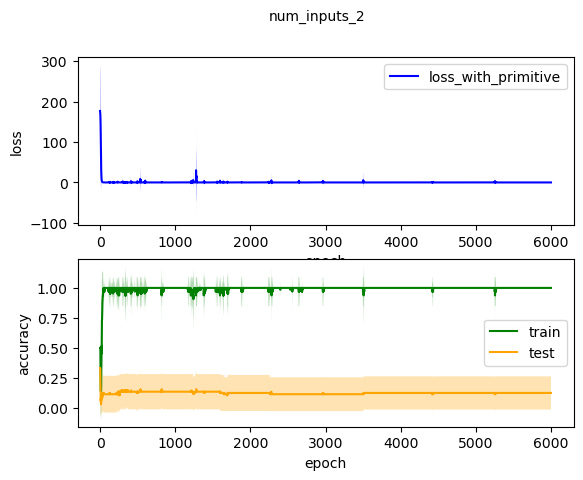

In [21]:
## 2 inputs with primitive training
t1 = time.time()
reses2 = Parallel(n_jobs = -1)(delayed(exp2)(2) for i in range(num_sims))

cuedicts_2 = [r['cue_dict'] for r in reses2]
all_losses2p = np.hstack([r['losses'] for r in reses2])
all_accs_train2p = np.array([r['accs'][:,0] for r in reses2]).T
all_accs_test2p = np.array([r['accs'][:,1] for r in reses2]).T
all_mods2p = [r['model'] for r in reses2]
all_tests2p = [r['testset'] for r in reses2]

plotNNs([all_losses2p], [all_accs_train2p, all_accs_test2p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(2), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

time:  6.495075015227


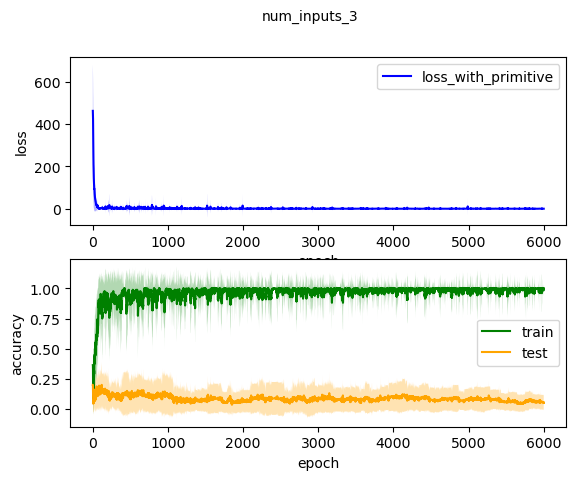

In [22]:
## 3 inputs with primitive training
t1 = time.time()
reses3 = Parallel(n_jobs = -1)(delayed(exp2)(3) for i in range(num_sims))

cuedicts_3 = [r['cue_dict'] for r in reses3]
all_losses3p = np.hstack([r['losses'] for r in reses3])
all_accs_train3p = np.array([r['accs'][:,0] for r in reses3]).T
all_accs_test3p = np.array([r['accs'][:,1] for r in reses3]).T
all_mods3p = [r['model'] for r in reses3]
all_tests3p = [r['testset'] for r in reses3]

plotNNs([all_losses3p], [all_accs_train3p, all_accs_test3p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(3), shift = 0)
t2 = time.time()
print('time: ', (t2-t1)/60)

time:  9.90195446809133


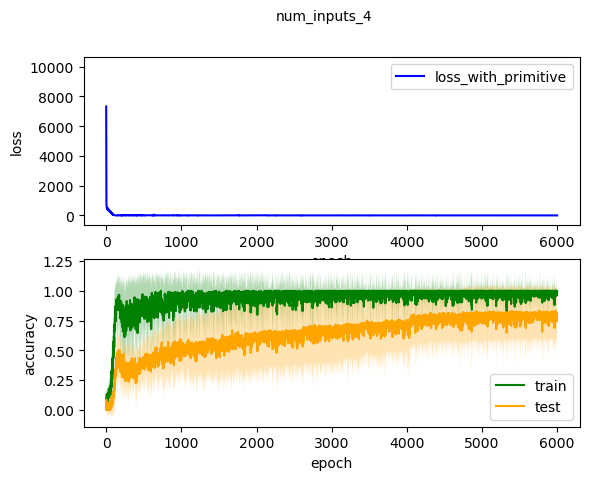

In [23]:
## 4 inputs with primitive training
t1 = time.time()
reses4 = Parallel(n_jobs = -1)(delayed(exp1)(4) for i in range(num_sims))

cuedicts_4 = [r['cue_dict'] for r in reses4]
all_losses4p = np.hstack([r['losses'] for r in reses4])
all_accs_train4p = np.array([r['accs'][:,0] for r in reses4]).T
all_accs_test4p = np.array([r['accs'][:,1] for r in reses4]).T
all_mods4p = [r['model'] for r in reses4]
all_tests4p = [r['testset'] for r in reses4]

plotNNs([all_losses4p], [all_accs_train4p, all_accs_test4p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(4), shift = 0)
t4 = time.time()
print('time: ', (t4-t1)/60)

time:  18.181687569618227


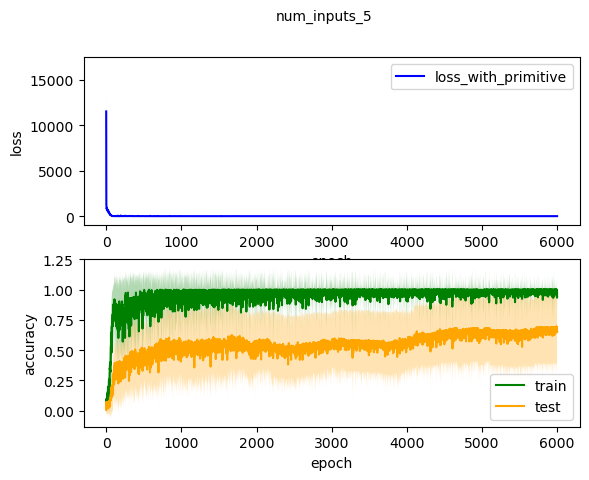

In [24]:
## 5 inputs with primitive training
t1 = time.time()
reses5 = Parallel(n_jobs = -1)(delayed(exp1)(5) for i in range(num_sims))

cuedicts_5 = [r['cue_dict'] for r in reses5]
all_losses5p = np.hstack([r['losses'] for r in reses5])
all_accs_train5p = np.array([r['accs'][:,0] for r in reses5]).T
all_accs_test5p = np.array([r['accs'][:,1] for r in reses5]).T
all_mods5p = [r['model'] for r in reses5]
all_tests5p = [r['testset'] for r in reses5]

plotNNs([all_losses5p], [all_accs_train5p, all_accs_test5p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(5), shift = 0)
t5 = time.time()
print('time: ', (t5-t1)/60)

time:  28.525991984208424


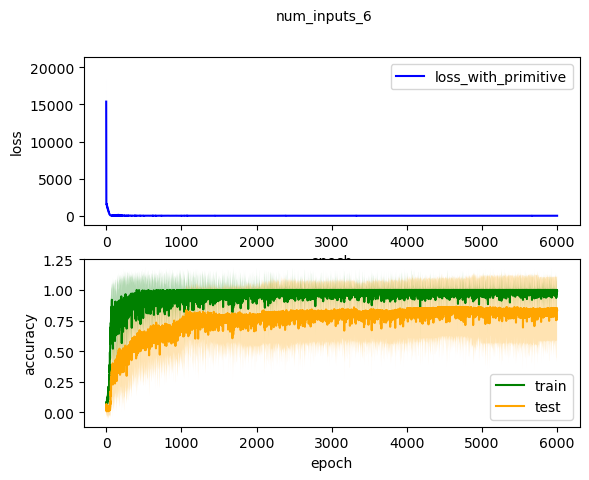

In [25]:
## 6 inputs with primitive training
t1 = time.time()
reses6 = Parallel(n_jobs = -1)(delayed(exp1)(6) for i in range(num_sims))

cuedicts_6 = [r['cue_dict'] for r in reses6]
all_losses6p = np.hstack([r['losses'] for r in reses6])
all_accs_train6p = np.array([r['accs'][:,0] for r in reses6]).T
all_accs_test6p = np.array([r['accs'][:,1] for r in reses6]).T
all_mods6p = [r['model'] for r in reses6]
all_tests6p = [r['testset'] for r in reses6]

plotNNs([all_losses6p], [all_accs_train6p, all_accs_test6p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(6), shift = 0)
t6 = time.time()
print('time: ', (t6-t1)/60)

time:  31.15814017057419


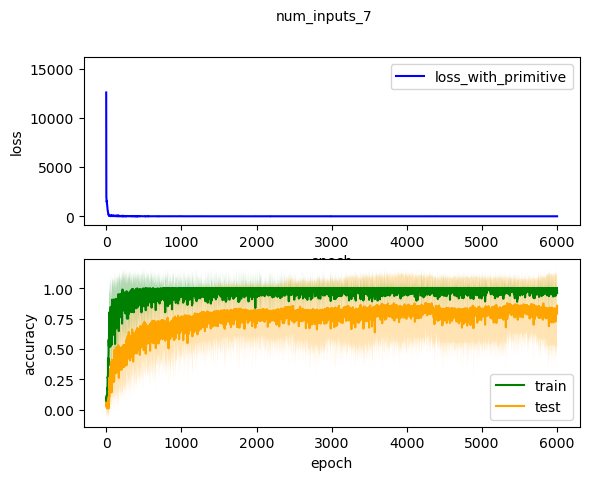

In [26]:
## 7 inputs with primitive training
t1 = time.time()
reses7 = Parallel(n_jobs = -1)(delayed(exp1)(7) for i in range(num_sims))

cuedicts_7 = [r['cue_dict'] for r in reses7]
all_losses7p = np.hstack([r['losses'] for r in reses7])
all_accs_train7p = np.array([r['accs'][:,0] for r in reses7]).T
all_accs_test7p = np.array([r['accs'][:,1] for r in reses7]).T
all_mods7p = [r['model'] for r in reses7]
all_tests7p = [r['testset'] for r in reses7]

plotNNs([all_losses7p], [all_accs_train7p, all_accs_test7p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(7), shift = 0)
t7 = time.time()
print('time: ', (t7-t1)/60)

time:  41.09173050324122


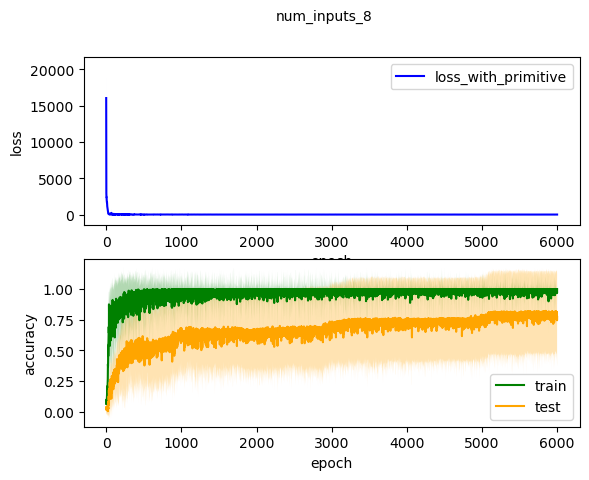

{'A': 11, 'B': 15, 'C': 13, 'D': 4}
loss: 0.0 
{'A': 15, 'B': 3, 'C': 12, 'D': 10}
loss: 0.1 
{'A': 2, 'B': 14, 'C': 15, 'D': 17, 'E': 4}
loss: 0.0 
{'A': 13, 'B': 7, 'C': 5, 'D': 10, 'E': 6}
loss: 0.0 
{'A': 9, 'B': 16, 'C': 10, 'D': 14, 'E': 11, 'F': 17}
loss: 0.0 
{'A': 13, 'B': 8, 'C': 7, 'D': 10, 'E': 6, 'F': 16}
loss: 0.0 
{'A': 10, 'B': 8, 'C': 14, 'D': 12, 'E': 16, 'F': 5, 'G': 6}
loss: 0.2 
{'A': 6, 'B': 15, 'C': 4, 'D': 14, 'E': 2, 'F': 7, 'G': 11}
loss: 0.1 
{'A': 11, 'B': 12, 'C': 13, 'D': 3, 'E': 9, 'F': 17, 'G': 8, 'H': 15}
loss: 0.0 
{'A': 3, 'B': 6, 'C': 17, 'D': 11, 'E': 7, 'F': 15, 'G': 10, 'H': 14}
loss: 0.0 
{'A': 15, 'B': 14, 'C': 13, 'D': 8}
loss: 0.1 
{'A': 10, 'B': 5, 'C': 9, 'D': 2}
loss: 0.0 
{'A': 16, 'B': 9, 'C': 5, 'D': 3, 'E': 4}
loss: 2.7 
{'A': 15, 'B': 8, 'C': 6, 'D': 12, 'E': 14}
loss: 0.9 
{'A': 17, 'B': 10, 'C': 2, 'D': 15, 'E': 14, 'F': 16}
loss: 1.3 
{'A': 17, 'B': 15, 'C': 8, 'D': 13, 'E': 7, 'F': 14}
loss: 0.0 
{'A': 5, 'B': 16, 'C': 14, 'D': 12,

In [27]:
## 8 inputs with primitive training
t1 = time.time()
reses8 = Parallel(n_jobs = -1)(delayed(exp1)(8) for i in range(num_sims))

cuedicts_8 = [r['cue_dict'] for r in reses8]
all_losses8p = np.hstack([r['losses'] for r in reses8])
all_accs_train8p = np.array([r['accs'][:,0] for r in reses8]).T
all_accs_test8p = np.array([r['accs'][:,1] for r in reses8]).T
all_mods8p = [r['model'] for r in reses8]
all_tests8p = [r['testset'] for r in reses8]

plotNNs([all_losses8p], [all_accs_train8p, all_accs_test8p], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'num_inputs_'+str(8), shift = 0)
t8 = time.time()
print('time: ', (t8-t1)/60)

In [29]:
savedir = '../results/Lake/2_subtraction/'

for i in range(1,8):
    with open(savedir+'reses'+str(i+1), 'wb') as f:
        pickle.dump(eval('reses'+ str(i+1)), f)
    

In [30]:
all_mods = [all_mods2p, all_mods3p, all_mods4p, all_mods5p,\
       all_mods6p, all_mods7p, all_mods8p]
all_tests = [all_tests2p, all_tests3p, all_tests4p, all_tests5p,\
        all_tests6p, all_tests7p, all_tests8p]

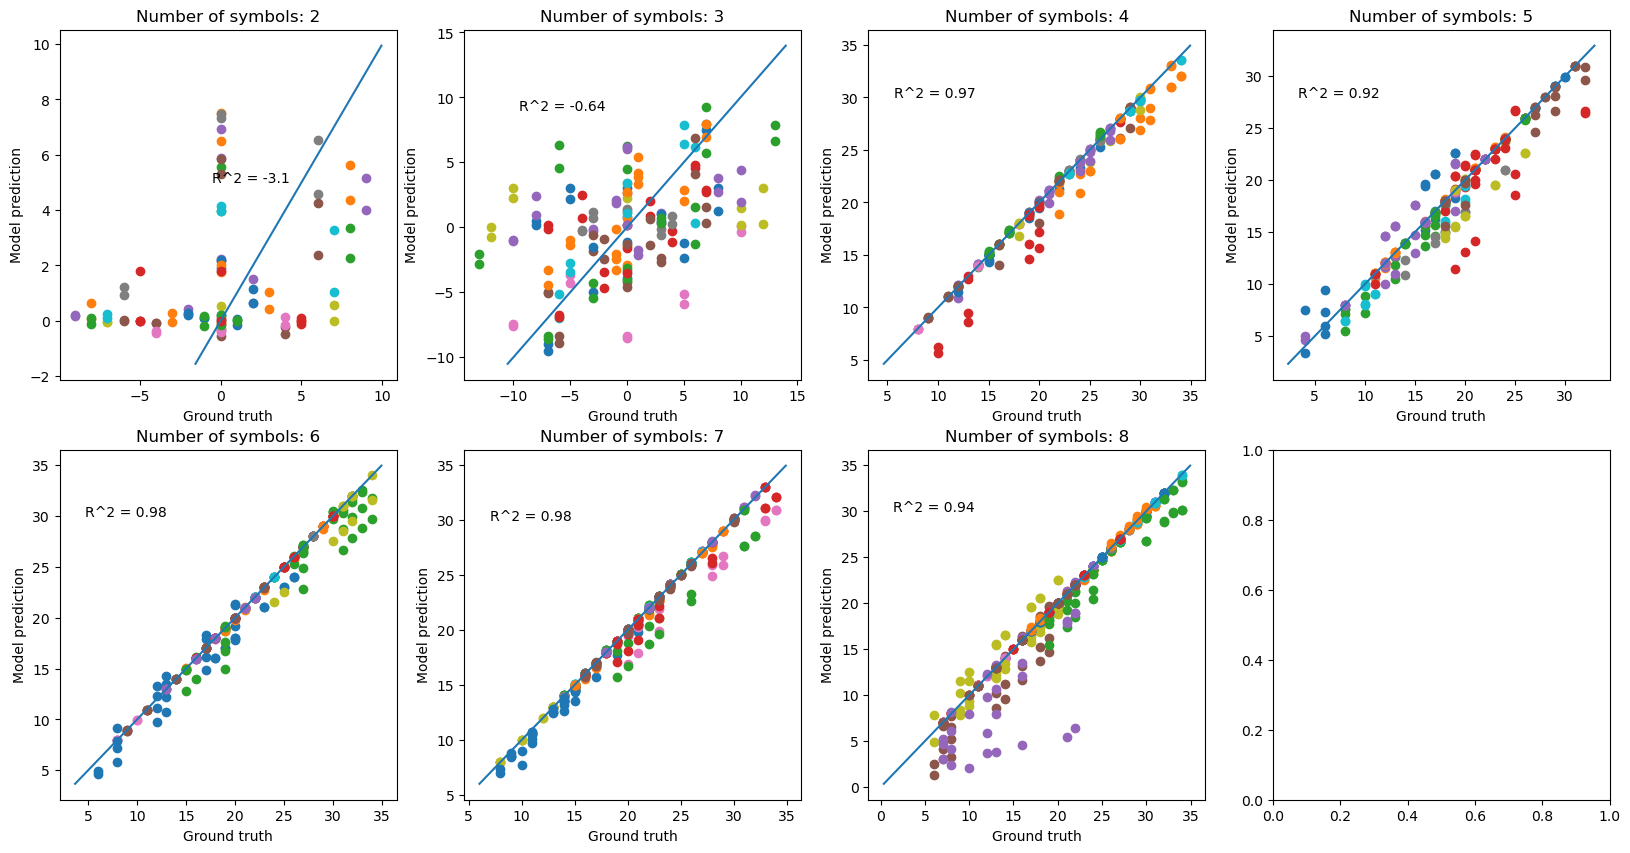

In [43]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, axs = plt.subplots(2, 4)
r2vals = []
for j in range(len(all_mods)):
    modlist = all_mods[j]
    testlist = all_tests[j]
    dfs = []
    for i in range(len(modlist)):
        df = test_preds(modlist[i], [testlist[i]], hidden_size)
        dfs.append(df)
        all_dfs = pd.concat(dfs) 
    preds, labs = all_dfs['pred'], all_dfs['label']
    xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
    ax = axs[math.floor(j/4), j%4]
    for d in dfs:
        ax.scatter(d['label'], d['pred'])
    ax.plot(xy,xy)
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Model prediction')
    ax.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)-4))
    ax.title.set_text('Number of symbols: '+str(j+2))
    r2vals.append(round(r2_score(all_dfs['pred'],all_dfs['label']), 2))
    


In [39]:
numinps = list(range(2,9))

Text(0, 0.5, 'R^2 score')

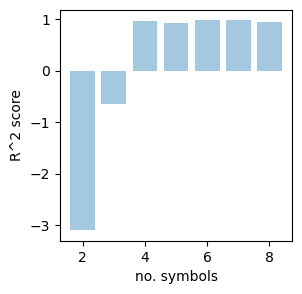

In [42]:
plt.rcParams["figure.figsize"] = (3, 3)
plt.bar(numinps, r2vals, alpha = 0.4)
plt.xlabel('no. symbols')
plt.ylabel('R^2 score')

## TODO:
save objects
plot scatter points correlations
plot r2 against number of inputs
look at RNNs accuracy trial - e.g how many fully accurate?

In [ ]:
from sklearn.metrics import r2_score

modlist = all_mods6p
testlist = all_tests6p
dfs = []
for i in range(len(modlist)):
    df = test_preds(modlist[i], [testlist[i]], hidden_size)
    dfs.append(df)
all_dfs = pd.concat(dfs) 
preds, labs = all_dfs['pred'], all_dfs['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)
for d in dfs:
    plt.scatter(d['pred'], d['label'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.annotate('R^2 = '+str(round(r2_score(all_dfs['pred'],all_dfs['label']), 2)),(np.min(preds),np.max(labs)))